In [56]:
import radicl 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from numpy import polyfit, poly1d, linspace, argwhere
import glob
import numpy as np
import math

In [57]:
## make plotting pretty
import seaborn as sns
sns.set_theme()

### CODE DESCRIPTION
Using the function surface_ground_crop(file), given a .csv file from the Realtime Adventure Data probe, finds the surface and ground and plots cropped profile. 

Auhtor: Anna Valentine, annadigssnow@gmail.com,  12/15/21

### USEFUL FUNCTIONS

In [58]:
## gives list of files in path
def list_files_local(path):
    """ Get file list form local folder. """
    from glob import glob
    return glob(path)

In [59]:
## finds nearest index of value given array 
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

In [10]:
## Import Files
file_path1 = 'MicahData01.07/*.csv'
file_path2 = 'FieldData12.04/*.csv'
files1 = list_files_local(file_path1)
files2 = list_files_local(file_path2)
print(len(files1))
print(len(files2))

10
14


In [11]:
### plots raw data of file
def plot_file_raw(file):

    df = pd.read_csv(file, header=5)

    p = [1.22E-6, -1.13886E-2, 26.343, -2927.6]
    poly = poly1d(p)

    sensor = poly(df['Sensor1'])


    meas_time = len(df['Sensor1']) / 1000 # Sample rate used by accident this day! UGH!
    accel_norm = (df['acceleration'] +  1).abs()
    
    #fig, axes = plt.subplots(ncols=2)

    # Plot hardness sensor with accel
    plt.figure(figsize=(10, 10))
    
    #ax = axes[0]
    plt.subplot(131)
    time = linspace(0, meas_time, len(df['Sensor1']))
    
    plt.plot(df['Sensor1'], time,'k',label='Force Raw')
    plt.plot(sensor, time, 'b', label="Force")    #### added in line
    plt.ylabel("Time Index")
    plt.xlabel("Force Raw Signal")
    plt.title("Force ")
    plt.gca().invert_yaxis()
    plt.legend()
    #ax1 = ax.twinx()

    plt.subplot(132)
    plt.title("Acceleration")
    plt.ylabel("Time Index")
    plt.xlabel("Acceleration (cm/s)")
    #time = linspace(0,meas_time, len(df['acceleration']))
    plt.plot((df['acceleration'] +  1).abs(), time,'b',label='accleration')
    plt.gca().invert_yaxis()
    
    plt.subplot(133)
    plt.title("Active/Near NIR")
    plt.ylabel("Time Index")
    plt.xlabel("NIR")
    plt.plot(df['Sensor2'], time+ 0.5, label = "Ambient NIR")
    plt.plot(df['Sensor3'], time+ 0.5, label = "Active NIR")
    plt.legend()
    plt.gca().invert_yaxis()
    
    
    plt.tight_layout()

    plt.show()

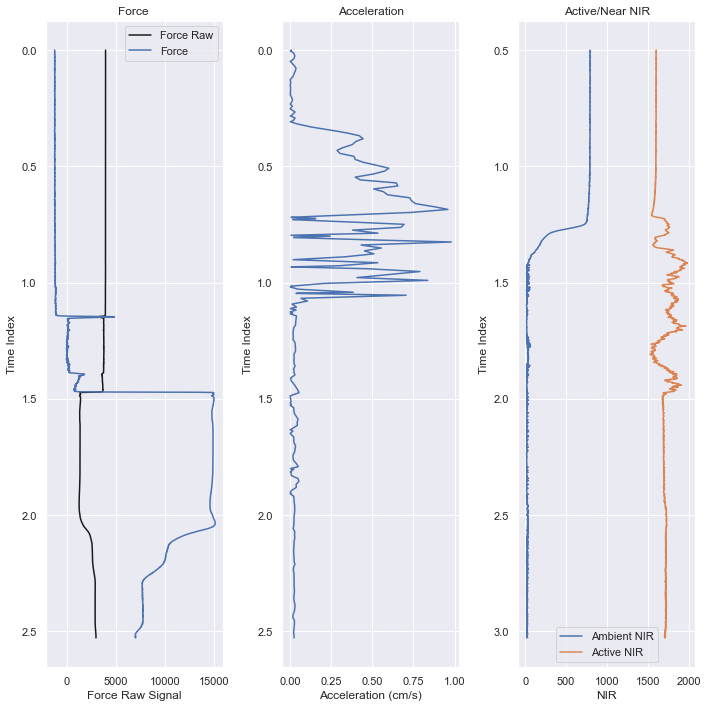

In [12]:
plot_file_raw(files1[0])

In [19]:
### Plotting function with just force and Active/Near IR
def plot_force_NIR(file):
    df = pd.read_csv(file, header=5)

    p = [1.22E-6, -1.13886E-2, 26.343, -2927.6]
    poly = poly1d(p)

    sensor = poly(df['Sensor1'])
    
    
    meas_time = len(df['Sensor1']) / 1000 # Sample rate used by accident this day! UGH!
    accel_norm = (df['acceleration'] +  1).abs()
    
    time = linspace(0, meas_time, len(df['Sensor1']))
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6), gridspec_kw={'width_ratios': [2, 1]})
    plt.suptitle("Uncropped Data", fontsize= 17)
    #f.figsize(10,10)
    #plt.figure(figsize=(10, 10))
    #plt.subplot(121)
    ax1.plot(sensor, time, 'b', label="Force")   
    ax1.set_ylabel("Time Index", fontsize=13)
    ax1.set_xlabel("Force (mN)", fontsize=13)
    ax1.set_title("Force", fontsize=15)
    
    #plt.subplot(122)
    ax2.plot(df['Sensor2'], time+0.25, label = "Ambient NIR")
    ax2.plot(df['Sensor3'], time+0.25, label = "Active NIR")

    #ax2.set_ylabel("Time Index")
    ax2.set_xlabel("(a.u.)", fontsize=14)
    ax2.set_title("Force & Near/Active IR", fontsize=13)
    
    plt.tight_layout()
    
    

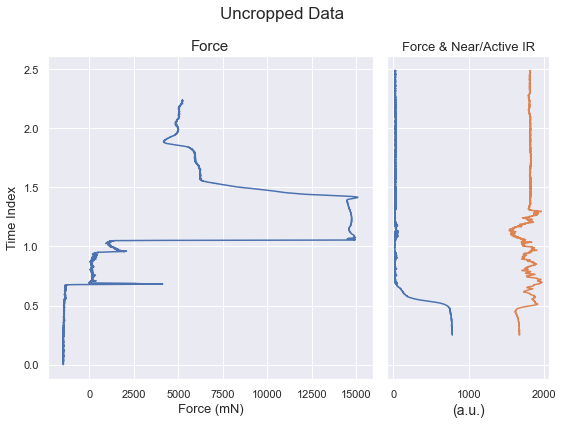

In [20]:
plot_force_NIR(files1[1])

In [21]:
###Smoothing function 
#https://swharden.com/blog/2010-06-20-smoothing-window-data-averaging-in-python-moving-triangle-tecnique/
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed


In [34]:
###Scheme to figure out where the NIR curve starts veering
def find_surface(file, plot=True):
    
    ## read in file
    df = pd.read_csv(file, header=5)
    
    ## calibration coeffs 
    p = [1.22E-6, -1.13886E-2, 26.343, -2927.6]
    #p2 = [1.60168e-06, -7.32247e-03, 0.401, 21515.1]  # dataset 2 calibaration coeffs
    poly = poly1d(p)

    ## apply coeffs 
    sensor = poly(df['Sensor1'])
    
    ## create a time index
    meas_time = len(df['Sensor1']) / 1000 # Sample rate used by accident this day! UGH!
    time = linspace(0, meas_time, len(df['Sensor1']))
    
    
    ## Smooth the data of ambient IR
    smooth_AIR = smoothTriangle(df['Sensor2'], 100)
    
    ##Find all the slopes
    m = np.diff(smooth_AIR)/np.diff(time)
    s_index = np.argmin(m)
    
    ## plot for testng 
    if plot: 
        plt.figure(figsize=(10, 10))
        plt.suptitle("Surface Detection", fontsize=16)
        plt.subplot(121)
        plt.title("Force Profile", fontsize =16)
        plt.ylabel("Time Index", fontsize=16)
        plt.xlabel("Force (mN)", fontsize=16)
        plt.plot(sensor, time, label = 'Force (mN)')
        plt.axhline(y=time[s_index], color='r', linestyle='-', label="Surface")
        plt.legend(prop={'size': 14})
        plt.gca().invert_yaxis()


        plt.subplot(122)
        plt.title("Smoothed Ambient IR", fontsize=16)
        plt.ylabel("Time Index", fontsize=16)
        plt.xlabel("a.u.", fontsize=16)
        plt.plot(smooth_AIR, time)
        plt.axhline(y=time[s_index], color='r', linestyle='-', label="Surface")
        plt.legend(prop={'size': 14})
        plt.gca().invert_yaxis()



        plt.tight_layout()
    
    ##return time index 
    return time[s_index]
    

0.30413774354327144

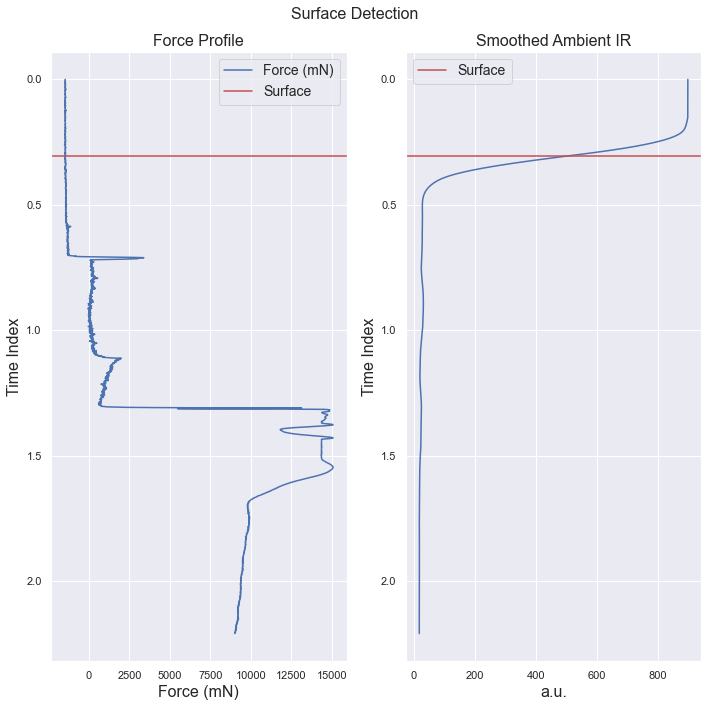

In [35]:
find_surface(files1[3])

In [46]:
def find_ground(file, plot=True):
    
    ## read in csv 
    df = pd.read_csv(file, header=5)
    
    ### apply calibration coefficients
    p = [1.22E-6, -1.13886E-2, 26.343, -2927.6]
    #p = [1.60168e-06, -7.32247e-03, 0.401, 21515.1]  # probe 2 calib coeffs
    poly = poly1d(p)

    ## force sensor
    sensor = poly(df['Sensor1'])
    
    ## create time index 
    meas_time = len(df['Sensor1']) / 1000 # Sample rate used by accident this day! UGH!
    time = linspace(0, meas_time, len(df['Sensor1']))
    
    ## create indexing, loop through and find best ground detection 
    index = []
    hi_slope = []
    for i in range(len(sensor)-4):
        if (sensor[i+4]-sensor[i] > 400) & (sensor[i]>8000):
            index.append(i)
            hi_slope.append(sensor[i])
     
    
    
    t_index = []
    ground_poss = []
    t_index2 = []
    
    ### find concurrent points 
    for i in range(len(index)):       
        t_index.append(time[index[i]])
        i1 = index[i]
        i2 = index[i-1] + 1
        i3 = index[i-2] + 2
       
        if (i1 == i2 == i3 ): ### if concurrent, add to list 
            ground_poss.append(sensor[i1])
            t_index2.append(time[i1])
            
    ### plot if needed 
    if (plot):
        plt.figure(figsize=(9, 9))
        plt.suptitle("Ground Detection", fontsize=16)


        plt.title("Scattered")
        plt.ylabel("Time Index", fontsize=15)
        plt.xlabel("Force (mN)", fontsize=15)
        plt.plot(sensor, time)
        plt.scatter(sensor, time, s=15, label="Force Data")
        plt.axhline(y=t_index2[0], color='r', linestyle='-', label="Ground Est")
        #plt.scatter(hi_slope, t_index, c='green')
        plt.scatter(ground_poss, t_index2, c='red', label="Points of Interest")
        plt.legend(prop={'size': 12})
        plt.gca().invert_yaxis()

    
    return t_index2[0]

2.0307554893933757

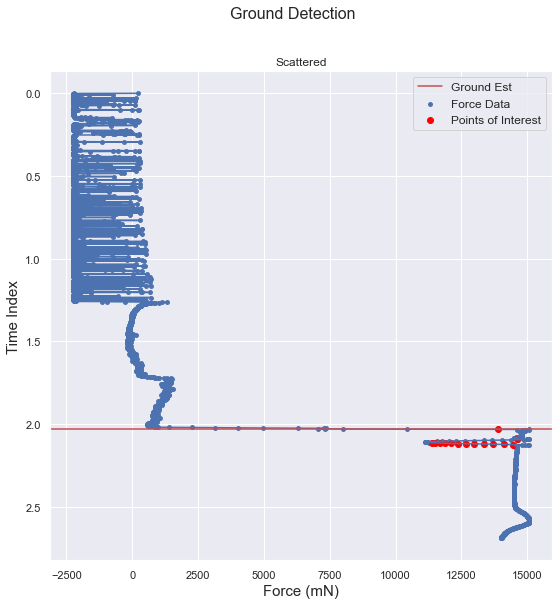

In [47]:
find_ground(files1[4])

In [60]:
### Find surface and ground  
def surface_ground_crop(file, plot=True): 
    
    ## Returns index of surface/ground
    surface = find_surface(file, plot=False)
    ground = find_ground(file, plot=False)
    
    
    
    ## Read in file elsewhere
    df = pd.read_csv(file, header=5)

    ## apply coefficients 
    p = [1.22E-6, -1.13886E-2, 26.343, -2927.6]
    poly = poly1d(p)

    sensor = poly(df['Sensor1'])
    
    meas_time = len(df['Sensor1']) / 1000 # Sample rate used by accident this day! UGH!
    accel_norm = (df['acceleration'] +  1).abs()
    
    time = linspace(0, meas_time, len(df['Sensor1']))
    
    ## create cropped data object 
    s_i = find_nearest(time, surface)
    g_i = find_nearest(time, ground)
    
    ## crop time indexes
    crop_force = sensor[s_i: g_i]
    crop_time = time[s_i: g_i]
    
    ### plotting
    if (plot):
    
        plt.figure(figsize=(8, 8))
        plt.suptitle("Dataset 1: File 3", fontsize=16)


        plt.subplot(121)
        plt.title("Uncropped", fontsize=15)
        plt.ylabel("Time Index", fontsize=15)
        plt.xlabel("Relative Force (mN)", fontsize=15)
        #plt.scatter(sensor, time, s=15, label="Force Data")
        plt.plot(sensor, time, label="Force Data")
        plt.axhline(y=ground,color='r', linestyle='-', label="Ground Est")
        plt.axhline(y=surface, color='orange', linestyle='-', label="Surface")
        
        plt.legend(prop={'size': 12})
        plt.gca().invert_yaxis()


        plt.subplot(122)
        
        depth = np.linspace(0, 75, len(crop_time))
        
        plt.title("Cropped Data", fontsize=15)
        plt.ylabel("Depth (cm)", fontsize=15)
        plt.xlabel("Relative Force (mN)", fontsize=15)
        plt.plot(crop_force, depth, label="Force Data")
        #plt.scatter(sensor, time, s=15, label="Force Data")
        plt.legend(prop={'size': 12})
        #plt.ylim(ground, surface)
        
        #plt.yticks(depth)
        
        plt.xlim(min(sensor)-100, 6000)
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
    

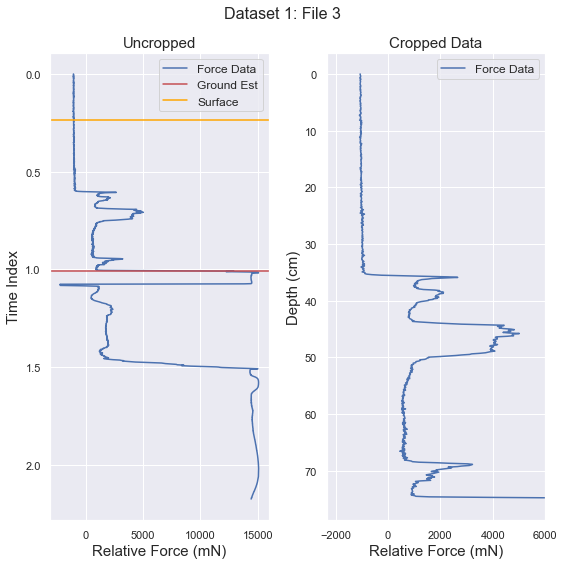

In [64]:
surface_ground_crop(files1[7])

## A BUNCH OF MESSY PLOTTING CODE FOR REPORT

In [48]:
### does same thing as find_ground, but plots for all profiles for my report
def plot_ground_profiles(files, plot=True):
    fig, axs = plt.subplots(3,3, figsize=(12, 12), facecolor='w', edgecolor='k')
    axs = axs.ravel() 
    
    for fnum in range(len(files)):
        file = files[fnum]

        df = pd.read_csv(file, header=5)

        p = [1.22E-6, -1.13886E-2, 26.343, -2927.6]
        poly = poly1d(p)

        sensor = poly(df['Sensor1'])

        meas_time = len(df['Sensor1']) / 1000 # Sample rate used by accident this day! UGH!
        accel_norm = (df['acceleration'] +  1).abs()

        time = linspace(0, meas_time, len(df['Sensor1']))

        index = []
        hi_slope = []
        for i in range(len(sensor)-4):
            if (sensor[i+4]-sensor[i] > 2000) & (sensor[i]>500):
                index.append(i)
                hi_slope.append(sensor[i])



        t_index = []
        ground_poss = []
        t_index2 = []

        for i in range(len(index)):

            t_index.append(time[index[i]])
            #print(index)

            i1 = index[i]
            i2 = index[i-1] + 1
            i3 = index[i-2] + 2
            i4 = index[i-3] + 3

            if (i1 == i2 == i3 == i4):
                #print("hello?")
                ground_poss.append(sensor[i1])
                t_index2.append(time[i1])



        
        
        title = "Dataset 1: File #"+ str(fnum)

        axs[fnum].invert_yaxis()
        axs[fnum].set_title(title, fontsize=16)
        axs[fnum].set_ylabel("Time Index", fontsize=15)
        axs[fnum].set_xlabel("Force (mN)", fontsize=15)
        axs[fnum].plot(sensor, time, linewidth=1)
        axs[fnum].scatter(sensor, time, s=15, label="Force Data")
        try: 
            axs[fnum].axhline(y=t_index2[0], color='r', linestyle='-', label="Ground Est")
        except: 
            print("fail")
        #plt.scatter(hi_slope, t_index, c='green')
        axs[fnum].scatter(ground_poss, t_index2, c='red', label="Points of Interest")
        axs[fnum].legend(prop={'size': 12})
        #plt.ylim(0.5, 2.25)


        plt.tight_layout()
    return t_index2[0]

0
1
2
3
4
5
fail
6
7
8
9


IndexError: index 9 is out of bounds for axis 0 with size 9

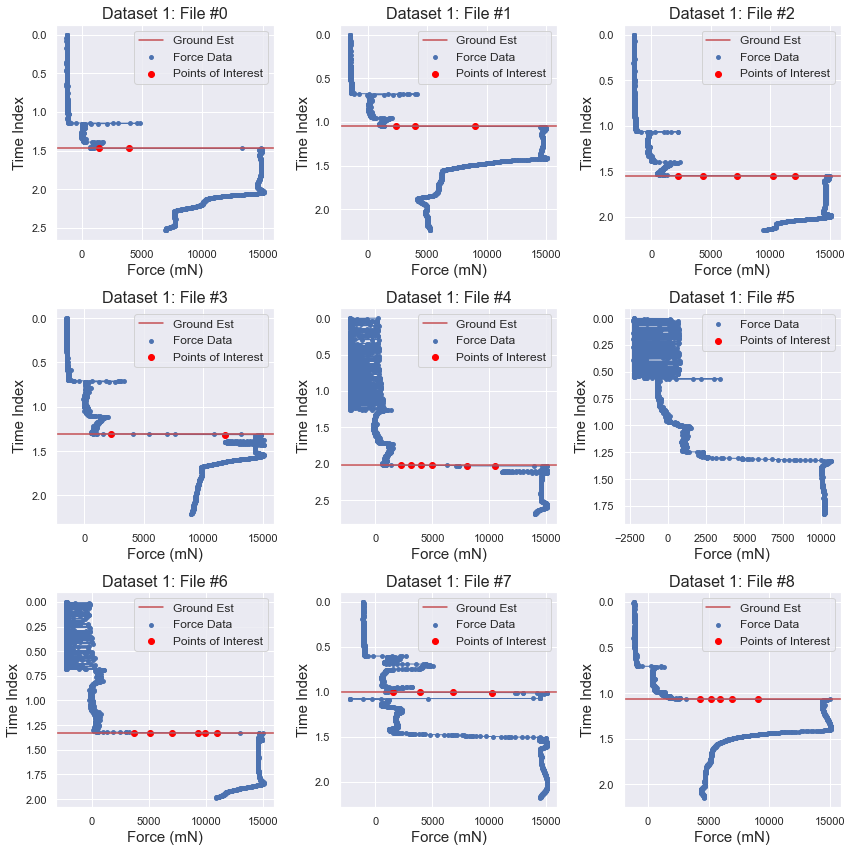

In [78]:
find_ground3(files)

In [96]:
def plot_SD(files, plot=True):
    fig, axs = plt.subplots(8,2, figsize=(10, 40), sharey=True,  edgecolor='k', gridspec_kw={'width_ratios': [2, 1]})
    axs = axs.ravel() 
    plti= 0
    axs[plti].invert_yaxis()
    for fnum in range(len(files)):
        print(fnum)
        file = files[fnum]

        df = pd.read_csv(file, header=5)

        p = [1.22E-6, -1.13886E-2, 26.343, -2927.6]
        poly = poly1d(p)

        sensor = poly(df['Sensor1'])

        meas_time = len(df['Sensor1']) / 1000 # Sample rate used by accident this day! UGH!
        accel_norm = (df['acceleration'] +  1).abs()

        time = linspace(0, meas_time, len(df['Sensor1']))

        ## Smooth the data 
        smooth_AIR = smoothTriangle(df['Sensor2'], 200)

        ##Find all the slopes
        m = np.diff(smooth_AIR)/np.diff(time)
        #surface = m.min()
        s_index = np.argmin(m)
        #print(s_index)

        
        
        title = "Dataset 1: File #"+ str(fnum)

        #plt.suptitle(title, fontsize=16)
        #plt.subplot(121)
        #axs[plti].invert_yaxis()
        axs[plti].set_title(title, fontsize =16)
        axs[plti].set_ylabel("Time Index", fontsize=16)
        axs[plti].set_xlabel("Force (mN)", fontsize=16)
        axs[plti].plot(sensor, time, label = 'Force (mN)')
        #axs[fnum].set_ylim(0,2.5)
        axs[plti].axhline(y=time[s_index-30]+0.2, color='r', linestyle='-', label="Surface")
        #plt.axhline(y=time[s_index], color='r', linestyle='-', label='surface estimate')
        axs[plti].legend(prop={'size': 14})

        plti+=1

        axs[plti].set_title("Smoothed Ambient IR", fontsize=16)
        axs[plti].set_xlabel("a.u.", fontsize=16)
        axs[plti].plot(smooth_AIR, time+0.2, color='green')
        axs[plti].axhline(y=time[s_index-30]+0.2, color='r', linestyle='-', label="Surface")
        axs[plti].legend(prop={'size': 14})
        
        plti+=1

        plt.tight_layout()

0
1
2
3
4
5
6
7
8


IndexError: index 16 is out of bounds for axis 0 with size 16

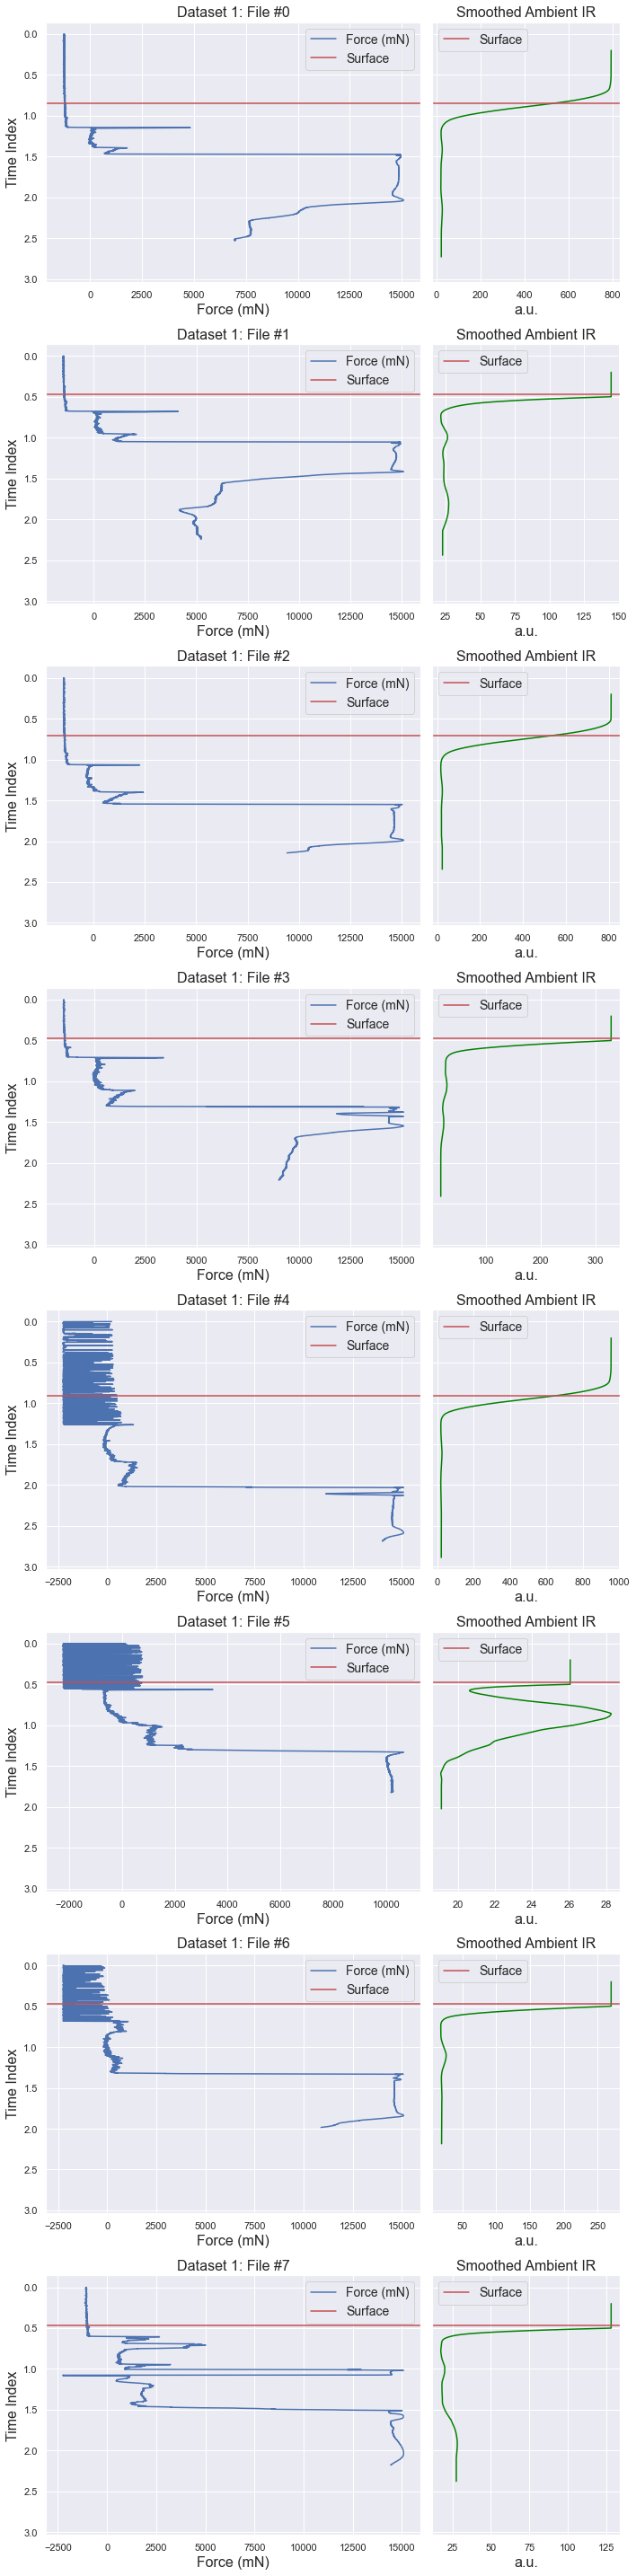

In [97]:
plot_SD(files)